#### GSE89093(46 Normal/46 Tumor)

In [33]:
import pandas as pd
liquid=pd.read_csv("../../乳癌液態/GSE89093/GSE89093_all_beta_normalized.csv")
liquid_label= liquid[liquid['0'].isin(['dummy'])].iloc[:,1::]
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg27494647','cg07445246','cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297','cg20388732']
method_gene['Cluster']=[1,1,1,1,2,3,3,4,4]
liquid= liquid[liquid['0'].isin(method_gene['ID'])]
liquid_label

c:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,88,89,90,91,92
453627,healthy,cancer-diagnosis,healthy,healthy,cancer-diagnosis,healthy,cancer-diagnosis,cancer-diagnosis,cancer-diagnosis,healthy,...,cancer-diagnosis,cancer-diagnosis,healthy,cancer-diagnosis,healthy,healthy,healthy,healthy,cancer-diagnosis,cancer-diagnosis


In [34]:
X_train = liquid.iloc[:, 1::]
x = [X_train.iloc[:, i].values.flatten().tolist() for i in range(92)]
y = [0 if liquid_label.iloc[0, i] == 'healthy' else 1 for i in range(liquid_label.shape[1])]

In [35]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix,accuracy_score
from itertools import combinations
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [36]:
def is_unique(lst):
    return len(lst) == len(set(lst))

In [38]:
#cv=5 >>f1 score:0.5
target_labels = method_gene['ID']
# 四個一組
combinations_list = list(combinations(target_labels, 4))
result=[]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 1
}

models = {
    'XGBoost': xgb.XGBClassifier(**params),
    'RandomForest': RandomForestClassifier(n_estimators=100, 
                                            max_depth=10, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2,
                                            min_impurity_decrease=0.0,
                                            random_state=42),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Tree': DecisionTreeClassifier()
}

for model_name, model in models.items():

    # 所有可能的組合
    for combination in combinations_list:

        GO_1=int(method_gene.loc[method_gene['ID'] == combination[0]]["Cluster"])
        GO_2=int(method_gene.loc[method_gene['ID'] == combination[1]]["Cluster"])
        GO_3=int(method_gene.loc[method_gene['ID'] == combination[2]]["Cluster"])
        GO_4=int(method_gene.loc[method_gene['ID'] == combination[3]]["Cluster"])

        lst=[GO_1,GO_2,GO_3,GO_4]

        if(is_unique(lst)):
            d1_values = liquid.loc[liquid['0']==combination[0]]
            d2_values = liquid.loc[liquid['0']==combination[1]]
            d3_values = liquid.loc[liquid['0']==combination[2]]
            d4_values = liquid.loc[liquid['0']==combination[3]]
        
            d1 = d1_values.iloc[:, 1::]
            d2 = d2_values.iloc[:, 1::]
            d3 = d3_values.iloc[:, 1::]
            d4 = d4_values.iloc[:, 1::]

            d1 = d1.values.flatten().tolist()
            d2 = d2.values.flatten().tolist()
            d3 = d3.values.flatten().tolist()
            d4 = d4.values.flatten().tolist()

            x = []

            for i in range(92):
                x.append([d1[i],d2[i],d3[i],d4[i]])
                
            cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
            average_accuracy = cv_scores.mean()

            # 獲取模型預測結果
            y_pred = cross_val_predict(model, x, y, cv=5)
            
            # 預測
            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(y, y_pred)
            f1 = f1_score(y, y_pred)

            sorted_combination = [x for _, x in sorted(zip(lst, combination))]
            result.append([model_name] + sorted_combination + [average_accuracy, auc_score, f1, sensitivity,specificity])
            
# result

In [39]:
from sklearn.metrics import classification_report
import numpy as np
print(classification_report(y, y_pred,labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           0       0.47      0.46      0.46        46
           1       0.47      0.48      0.47        46

    accuracy                           0.47        92
   macro avg       0.47      0.47      0.47        92
weighted avg       0.47      0.47      0.47        92



In [40]:
df=pd.DataFrame(result, columns=['Model','ID1', 'ID2', 'ID3','ID4', 'average_accuracy','AUC','f1_score','sensitivity','specificity'])
df.to_csv("../result/liquid_predict/liquid_combination.csv", index=False)

結論：GSE89093預測結果極差

#### GSE148663烏拉圭(22 Normal/22 Tumor)

In [42]:
import pandas as pd
liquid=pd.read_csv("../../乳癌液態/GSE148663烏拉圭/all_beta_normalized_breast_liquid_oversample_random.csv")
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297']
method_gene['Cluster']=[1,1,2,3,3,4]
liquid= liquid[liquid['Unnamed: 0'].isin(method_gene['ID'])]

liquid

,Unnamed: 0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21
31654,cg14502484,0.205051,0.243212,0.259744,0.275523,0.198522,0.283869,0.275523,0.243212,0.259744,...,0.157093,0.267130,0.199354,0.139707,0.128392,0.175718,0.287906,0.260111,0.197612,0.090689
50299,cg07792478,0.253777,0.268278,0.348533,0.427417,0.230685,0.383407,0.427417,0.268278,0.348533,...,0.205022,0.385772,0.266477,0.183004,0.236001,0.229289,0.332963,0.269127,0.242391,0.161024
53205,cg24848035,0.183613,0.189180,0.215913,0.224664,0.202534,0.209803,0.224664,0.189180,0.215913,...,0.171768,0.212201,0.142507,0.144872,0.160800,0.126820,0.178107,0.182490,0.193848,0.156214
102837,cg14231297,0.290047,0.371885,0.421400,0.431674,0.369174,0.401251,0.431674,0.371885,0.421400,...,0.260778,0.396896,0.286947,0.254129,0.356989,0.255084,0.433508,0.371220,0.322125,0.214401
176377,cg17152757,0.218125,0.262243,0.415552,0.363892,0.222247,0.362775,0.363892,0.262243,0.415552,...,0.123788,0.352934,0.200195,0.124532,0.138041,0.271143,0.167427,0.572455,0.282025,0.194151
291276,cg04574090,0.351352,0.300938,0.528000,0.594904,0.362397,0.468654,0.594904,0.300938,0.528000,...,0.229533,0.443259,0.334782,0.166949,0.344996,0.227562,0.472871,0.494785,0.392069,0.129789


In [43]:
X_train = liquid.iloc[:, 1::]
x = [X_train.iloc[:, i].values.flatten().tolist() for i in range(44)]
y = [ (0 if i < 22 else 1)  for i in range(44)]

In [44]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix,accuracy_score
from itertools import combinations
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [45]:
def is_unique(lst):
    return len(lst) == len(set(lst))

In [47]:
#cv=5
target_labels = method_gene['ID']
# 四個一組
combinations_list = list(combinations(target_labels, 4))
result=[]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 1
}
models = {
    'XGBoost': xgb.XGBClassifier(**params),
    'RandomForest': RandomForestClassifier(n_estimators=100, 
                                            max_depth=10, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2,
                                            min_impurity_decrease=0.0,
                                            random_state=42),
    'SVM': SVC(kernel='linear'),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

for model_name, model in models.items():

    # 所有可能的組合
    for combination in combinations_list:

        GO_1=int(method_gene.loc[method_gene['ID'] == combination[0]]["Cluster"])
        GO_2=int(method_gene.loc[method_gene['ID'] == combination[1]]["Cluster"])
        GO_3=int(method_gene.loc[method_gene['ID'] == combination[2]]["Cluster"])
        GO_4=int(method_gene.loc[method_gene['ID'] == combination[3]]["Cluster"])

        lst=[GO_1,GO_2,GO_3,GO_4]

        if(is_unique(lst)):
            d1_values = liquid.loc[liquid['Unnamed: 0']==combination[0]]
            d2_values = liquid.loc[liquid['Unnamed: 0']==combination[1]]
            d3_values = liquid.loc[liquid['Unnamed: 0']==combination[2]]
            d4_values = liquid.loc[liquid['Unnamed: 0']==combination[3]]
        
            d1 = d1_values.iloc[:, 1::]
            d2 = d2_values.iloc[:, 1::]
            d3 = d3_values.iloc[:, 1::]
            d4 = d4_values.iloc[:, 1::]

            d1 = d1.values.flatten().tolist()
            d2 = d2.values.flatten().tolist()
            d3 = d3.values.flatten().tolist()
            d4 = d4.values.flatten().tolist()

            x = []

            for i in range(44):
                x.append([d1[i],d2[i],d3[i],d4[i]])
                
            cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
            average_accuracy = cv_scores.mean()

            # 獲取模型預測結果
            y_pred = cross_val_predict(model, x, y, cv=5)
            
            # 預測
            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(y, y_pred)
            f1 = f1_score(y, y_pred)

            sorted_combination = [x for _, x in sorted(zip(lst, combination))]
            result.append([model_name] + sorted_combination + [average_accuracy, auc_score, f1, sensitivity,specificity])
            
# result

In [48]:
from sklearn.metrics import classification_report
import numpy as np
print(classification_report(y,y_pred,labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83        22
           1       0.85      0.77      0.81        22

    accuracy                           0.82        44
   macro avg       0.82      0.82      0.82        44
weighted avg       0.82      0.82      0.82        44



In [49]:
df=pd.DataFrame(result, columns=['Model','ID1', 'ID2', 'ID3','ID4', 'average_accuracy','AUC','f1_score','sensitivity','specificity'])
df.to_csv("../result/liquid_predict/liquid_combination_GSE148663.csv", index=False)

結論：預測結果f1 score平均約0.7

#### GSE237036 Tissue850K(60 Normal/100 Tumor)

In [50]:
import pandas as pd
tissue=pd.read_csv("../../乳癌資料集850/all_beta_normalized_850(GSE237036_RAW).csv")
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297']
method_gene['Cluster']=[1,1,2,3,3,4]
tissue= tissue[tissue['Unnamed: 0'].isin(method_gene['ID'])]
tissue

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
232748,cg04574090,0.244025,0.244025,0.341107,0.341107,0.370727,0.370727,0.237975,0.237975,0.213642,...,0.321294,0.321294,0.271298,0.271298,0.298351,0.298351,0.276520,0.276520,0.349054,0.349054
263583,cg17152757,0.165598,0.165598,0.228764,0.228764,0.213109,0.213109,0.155216,0.155216,0.184993,...,0.127308,0.127308,0.205972,0.205972,0.284642,0.284642,0.142922,0.142922,0.164962,0.164962
630111,cg24848035,0.241207,0.241207,0.339262,0.339262,0.304739,0.304739,0.255299,0.255299,0.335538,...,0.235159,0.235159,0.366768,0.366768,0.516118,0.516118,0.255146,0.255146,0.338493,0.338493
657083,cg07792478,0.296044,0.296044,0.385078,0.385078,0.313452,0.313452,0.233926,0.233926,0.294255,...,0.221863,0.221863,0.485509,0.485509,0.436295,0.436295,0.299842,0.299842,0.340356,0.340356
708907,cg14502484,0.239994,0.239994,0.344066,0.344066,0.302119,0.302119,0.192948,0.192948,0.299561,...,0.199828,0.199828,0.311484,0.311484,0.407607,0.407607,0.248074,0.248074,0.297350,0.297350
713786,cg14231297,0.368363,0.368363,0.472749,0.472749,0.420688,0.420688,0.294675,0.294675,0.398067,...,0.326816,0.326816,0.493422,0.493422,0.441660,0.441660,0.360619,0.360619,0.372375,0.372375


In [52]:
X_train = tissue.iloc[:, 1::2]
y = [ (1 if i < 100 else 0)  for i in range(160)]

In [53]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix,accuracy_score
from itertools import combinations
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [54]:
def is_unique(lst):
    return len(lst) == len(set(lst))

In [55]:
#cv=5
target_labels = method_gene['ID']
# 四個一組
combinations_list = list(combinations(target_labels, 4))
result=[]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  
    'max_depth': 3,
    'learning_rate': 1
}
models = {
    'XGBoost': xgb.XGBClassifier(**params),
    'RandomForest': RandomForestClassifier(n_estimators=100, 
                                            max_depth=10, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2,
                                            min_impurity_decrease=0.0,
                                            random_state=42),
    'SVM': SVC(kernel='linear'),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

for model_name, model in models.items():

    # 所有可能的組合
    for combination in combinations_list:

        GO_1=int(method_gene.loc[method_gene['ID'] == combination[0]]["Cluster"])
        GO_2=int(method_gene.loc[method_gene['ID'] == combination[1]]["Cluster"])
        GO_3=int(method_gene.loc[method_gene['ID'] == combination[2]]["Cluster"])
        GO_4=int(method_gene.loc[method_gene['ID'] == combination[3]]["Cluster"])

        lst=[GO_1,GO_2,GO_3,GO_4]

        if(is_unique(lst)):
            d1_values = tissue.loc[tissue['Unnamed: 0']==combination[0]]
            d2_values = tissue.loc[tissue['Unnamed: 0']==combination[1]]
            d3_values = tissue.loc[tissue['Unnamed: 0']==combination[2]]
            d4_values = tissue.loc[tissue['Unnamed: 0']==combination[3]]
        
            d1 = d1_values.iloc[:, 1::]
            d2 = d2_values.iloc[:, 1::]
            d3 = d3_values.iloc[:, 1::]
            d4 = d4_values.iloc[:, 1::]

            d1 = d1.values.flatten().tolist()
            d2 = d2.values.flatten().tolist()
            d3 = d3.values.flatten().tolist()
            d4 = d4.values.flatten().tolist()

            x = []

            for i in range(160):
                x.append([d1[i],d2[i],d3[i],d4[i]])
                
            cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
            
            average_accuracy = cv_scores.mean()

            # 獲取模型預測結果
            y_pred = cross_val_predict(model, x, y, cv=5)
            
            # 預測
            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)

            auc_score = roc_auc_score(y, y_pred)
            f1 = f1_score(y, y_pred)

            sorted_combination = [x for _, x in sorted(zip(lst, combination))]
            result.append([model_name] + sorted_combination + [average_accuracy, auc_score, f1, sensitivity,specificity])
            
# result

In [56]:
from sklearn.metrics import classification_report
import numpy as np
print(classification_report(y,y_pred,labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           0       0.37      0.37      0.37        60
           1       0.62      0.62      0.62       100

    accuracy                           0.53       160
   macro avg       0.49      0.49      0.49       160
weighted avg       0.53      0.53      0.53       160



In [57]:
df=pd.DataFrame(result, columns=['Model','ID1', 'ID2', 'ID3','ID4', 'average_accuracy','AUC','f1_score','sensitivity','specificity'])
df.to_csv("../result/850K_combination_GSE237036.csv", index=False)

結論：預測結果F1 score平均約0.6/0.7

#### 使用GSE89093(46 Normal/46 Tumor)訓練後，GSE148663烏拉圭(22 Normal/22 Tumor)測試

In [58]:
import pandas as pd
liquid=pd.read_csv("../../乳癌液態/GSE89093/GSE89093_all_beta_normalized.csv")
liquid_label= liquid[liquid['0'].isin(['dummy'])].iloc[:,1::]
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297']
method_gene['Cluster']=[1,1,2,3,3,4]
liquid= liquid[liquid['0'].isin(method_gene['ID'])]
liquid_label

c:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,87,88,89,90,91,92
453627,healthy,cancer-diagnosis,healthy,healthy,cancer-diagnosis,healthy,cancer-diagnosis,cancer-diagnosis,cancer-diagnosis,healthy,...,cancer-diagnosis,cancer-diagnosis,healthy,cancer-diagnosis,healthy,healthy,healthy,healthy,cancer-diagnosis,cancer-diagnosis


In [59]:
X_train = liquid.iloc[:, 1::]
X_train = [X_train.iloc[:, i].values.flatten().tolist() for i in range(92)]
y_train = [0 if liquid_label.iloc[0, i] == 'healthy' else 1 for i in range(liquid_label.shape[1])]

In [60]:
liquid=pd.read_csv("../../乳癌液態/GSE148663烏拉圭/all_beta_normalized_breast_liquid_oversample_random.csv")
liquid= liquid[liquid['Unnamed: 0'].isin(method_gene['ID'])]
liquid

,Unnamed: 0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21
31654,cg14502484,0.205051,0.243212,0.259744,0.275523,0.198522,0.283869,0.275523,0.243212,0.259744,...,0.157093,0.267130,0.199354,0.139707,0.128392,0.175718,0.287906,0.260111,0.197612,0.090689
50299,cg07792478,0.253777,0.268278,0.348533,0.427417,0.230685,0.383407,0.427417,0.268278,0.348533,...,0.205022,0.385772,0.266477,0.183004,0.236001,0.229289,0.332963,0.269127,0.242391,0.161024
53205,cg24848035,0.183613,0.189180,0.215913,0.224664,0.202534,0.209803,0.224664,0.189180,0.215913,...,0.171768,0.212201,0.142507,0.144872,0.160800,0.126820,0.178107,0.182490,0.193848,0.156214
102837,cg14231297,0.290047,0.371885,0.421400,0.431674,0.369174,0.401251,0.431674,0.371885,0.421400,...,0.260778,0.396896,0.286947,0.254129,0.356989,0.255084,0.433508,0.371220,0.322125,0.214401
176377,cg17152757,0.218125,0.262243,0.415552,0.363892,0.222247,0.362775,0.363892,0.262243,0.415552,...,0.123788,0.352934,0.200195,0.124532,0.138041,0.271143,0.167427,0.572455,0.282025,0.194151
291276,cg04574090,0.351352,0.300938,0.528000,0.594904,0.362397,0.468654,0.594904,0.300938,0.528000,...,0.229533,0.443259,0.334782,0.166949,0.344996,0.227562,0.472871,0.494785,0.392069,0.129789


In [61]:
X_test = liquid.iloc[:, 1::]
X_test = [X_test.iloc[:, i].values.flatten().tolist() for i in range(44)]
y_test = [ (0 if i < 22 else 1)  for i in range(44)]

In [62]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix,accuracy_score
from itertools import combinations
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge

In [63]:
def is_unique(lst):
    return len(lst) == len(set(lst))

In [64]:
target_labels = method_gene['ID']
# 四個一組
combinations_list = list(combinations(target_labels, 4))
result=[]

params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss', 
    'max_depth': 3,
    'learning_rate': 1
}
models = {
    'XGBoost': xgb.XGBClassifier(**params),
    'RandomForest': RandomForestClassifier(n_estimators=100, 
                                            max_depth=10, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2,
                                            min_impurity_decrease=0.0,
                                            random_state=42),
    'SVM': SVC(kernel='linear'),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

for model_name, model in models.items():

    # 所有可能的組合
    for combination in combinations_list:

        GO_1=int(method_gene.loc[method_gene['ID'] == combination[0]]["Cluster"])
        GO_2=int(method_gene.loc[method_gene['ID'] == combination[1]]["Cluster"])
        GO_3=int(method_gene.loc[method_gene['ID'] == combination[2]]["Cluster"])
        GO_4=int(method_gene.loc[method_gene['ID'] == combination[3]]["Cluster"])

        lst=[GO_1,GO_2,GO_3,GO_4]

        if(is_unique(lst)):
            d1_values = liquid.loc[liquid['Unnamed: 0']==combination[0]]
            d2_values = liquid.loc[liquid['Unnamed: 0']==combination[1]]
            d3_values = liquid.loc[liquid['Unnamed: 0']==combination[2]]
            d4_values = liquid.loc[liquid['Unnamed: 0']==combination[3]]
        
            d1 = d1_values.iloc[:, 1::]
            d2 = d2_values.iloc[:, 1::]
            d3 = d3_values.iloc[:, 1::]
            d4 = d4_values.iloc[:, 1::]

            d1 = d1.values.flatten().tolist()
            d2 = d2.values.flatten().tolist()
            d3 = d3.values.flatten().tolist()
            d4 = d4.values.flatten().tolist()

            x = []

            for i in range(44):
                x.append([d1[i],d2[i],d3[i],d4[i]])

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            auc_score = roc_auc_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            precision = tp / (tp + fp)
            sorted_combination = [x for _, x in sorted(zip(lst, combination))]
            result.append([model_name] + sorted_combination + [accuracy, auc_score, f1, sensitivity, specificity, precision])

<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
<ipython-input-64-494cce65b73e>:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision =

In [65]:
from sklearn.metrics import classification_report
import numpy as np
print(classification_report(y_test,y_pred,labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        22

   micro avg       0.50      1.00      0.67        22
   macro avg       0.50      1.00      0.67        22
weighted avg       0.50      1.00      0.67        22



In [66]:
df=pd.DataFrame(result, columns=['Model','ID1', 'ID2', 'ID3','ID4', 'accuracy','AUC','f1_score','sensitivity','specificity','precision'])
df.to_csv("../result/liquid_predict/liquid_combination_GSE89093&148663.csv", index=False)

結論：預測結果極差，可能過擬合

#### 查看6個基因的IQR分布

In [67]:
#GSE89093(46Normal/46Tumor)
import pandas as pd
liquid=pd.read_csv("../../乳癌液態/GSE89093/GSE89093_all_beta_normalized.csv")
liquid_label= liquid[liquid['0'].isin(['dummy'])].iloc[:,1::]
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297']
method_gene['Cluster']=[1,1,2,3,3,4]
liquid= liquid[liquid['0'].isin(method_gene['ID'])]

liquid.iloc[:, 0]

c:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


85611     cg04574090
141557    cg07792478
246866    cg14231297
251927    cg14502484
293600    cg17152757
407311    cg24848035
Name: 0, dtype: object

In [68]:
liquid_normal = []
liquid_tumor = []
for i in range(liquid_label.shape[1]):
    if liquid_label.iloc[0, i] == 'healthy':
        liquid_normal.append(liquid.iloc[:,i+1])
    else:
        liquid_tumor.append(liquid.iloc[:,i+1])

In [69]:
liquid_normal=pd.DataFrame(liquid_normal).T
liquid_tumor=pd.DataFrame(liquid_tumor).T
liquid_normal = liquid_normal.astype(float)
liquid_tumor = liquid_tumor.astype(float)
liquid_tumor=pd.concat([liquid.iloc[:, 0],liquid_tumor], axis=1)
liquid_normal=pd.concat([liquid.iloc[:, 0],liquid_normal], axis=1)
liquid_normal

,0,1,3,4,6,10,12,13,14,18,...,75,77,78,81,82,85,87,88,89,90
85611,cg04574090,0.087624,0.132369,0.108854,0.112986,0.100562,0.151417,0.097048,0.206180,0.236139,...,0.162224,0.152447,0.243475,0.173116,0.173296,0.147084,0.176534,0.238067,0.092072,0.203575
141557,cg07792478,0.106046,0.196431,0.249864,0.156220,0.137725,0.143231,0.137874,0.303932,0.395210,...,0.158096,0.227898,0.304839,0.208821,0.184704,0.162460,0.204782,0.254183,0.187526,0.196654
246866,cg14231297,0.148112,0.256395,0.228758,0.231946,0.170099,0.227932,0.167742,0.345759,0.368991,...,0.279759,0.329980,0.325323,0.180524,0.226752,0.189755,0.205174,0.330092,0.220389,0.198066
251927,cg14502484,0.080354,0.105511,0.083873,0.093481,0.060548,0.042506,0.060264,0.162111,0.221530,...,0.091979,0.118986,0.169647,0.085026,0.117588,0.074643,0.095737,0.208616,0.109698,0.112021
293600,cg17152757,0.079446,0.116854,0.097704,0.109604,0.092282,0.097519,0.094922,0.121711,0.153676,...,0.126167,0.149531,0.204663,0.099989,0.116686,0.096713,0.099148,0.135249,0.120283,0.156982
407311,cg24848035,0.051859,0.099801,0.082997,0.077364,0.060717,0.063073,0.069448,0.163496,0.226019,...,0.099526,0.175974,0.166129,0.087807,0.112337,0.078920,0.109812,0.162560,0.084828,0.086182


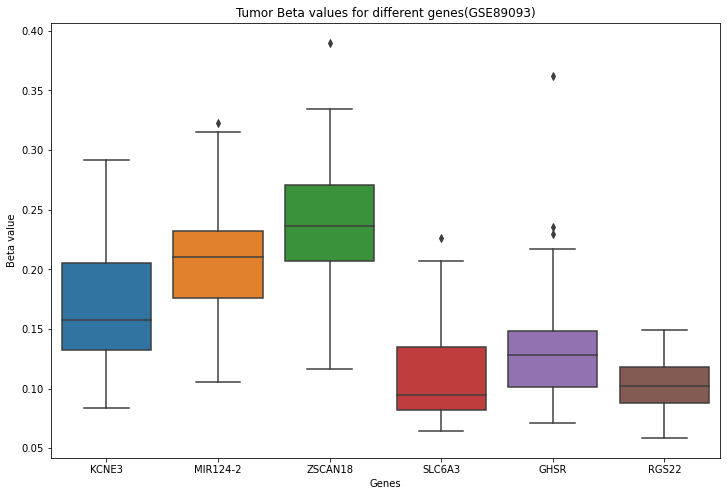

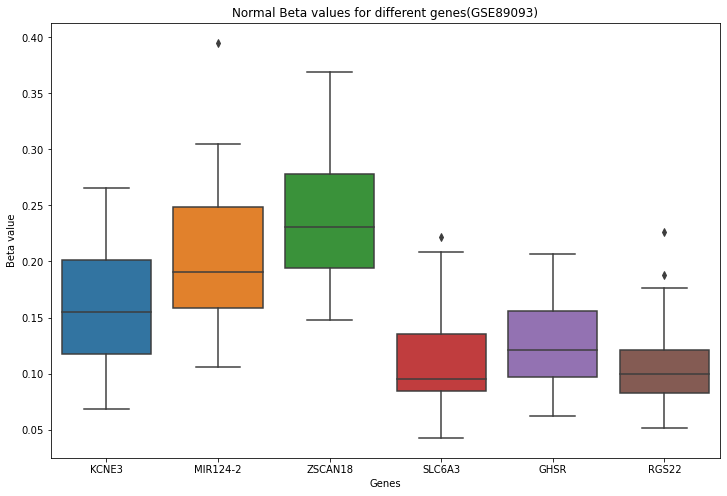

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_IQR_GSE89093(df,title):
    plt.figure(figsize=(12, 8))

    sns.boxplot(data=df.iloc[:,1::].T, orient='v')

    labels = ['KCNE3', 'MIR124-2', 'ZSCAN18', 'SLC6A3', 'GHSR', 'RGS22']
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
    plt.title(f'{title} Beta values for different genes(GSE89093)')
    plt.xlabel('Genes')
    plt.ylabel('Beta value')
    plt.show()

draw_IQR_GSE89093(liquid_tumor,'Tumor')
draw_IQR_GSE89093(liquid_normal,'Normal')

In [71]:
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR*1.5
    lower_fence = Q1 - IQR*1.5
    return upper_fence,lower_fence
def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf=df[(df>lower_fence)&(df<upper_fence)]
    return ddf

def cal_dbeta(liquid_normal,liquid_tumor,ID):  
    liquid_normal = no_outlier(liquid_normal.iloc[:,1::])
    liquid_tumor = no_outlier(liquid_tumor.iloc[:,1::])
    liquid_normal_avg = liquid_normal.mean(skipna=True, axis = 1)
    liquid_tumor=(liquid_tumor).subtract(liquid_normal_avg, axis = 0)
    liquid_tumor=no_outlier(liquid_tumor)
    liquid_tumor_mean = liquid_tumor.mean(skipna=True, axis = 1)
    Δβ = pd.merge(ID, pd.DataFrame(liquid_tumor_mean, columns = ["dbeta"]), left_index=True, right_index=True)
    return Δβ

# 計算6個基因的Δβ
cal_dbeta(liquid_normal,liquid_tumor,liquid.iloc[:,0])

,0,dbeta
85611,cg04574090,-0.001669
141557,cg07792478,0.008732
246866,cg14231297,-0.003469
251927,cg14502484,0.001757
293600,cg17152757,0.002623
407311,cg24848035,-0.007553


In [72]:
#GSE148663烏拉圭(22Normal/22Tumor)
liquid=pd.read_csv("../../乳癌液態/GSE148663烏拉圭/all_beta_normalized_breast_liquid_oversample_random.csv")
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297']
method_gene['Cluster']=[1,1,2,3,3,4]
liquid= liquid[liquid['Unnamed: 0'].isin(method_gene['ID'])]

liquid.iloc[:, 0]

31654     cg14502484
50299     cg07792478
53205     cg24848035
102837    cg14231297
176377    cg17152757
291276    cg04574090
Name: Unnamed: 0, dtype: object

In [73]:
liquid_normal = []
liquid_tumor = []
for i in range(44):
    if i < 22:
        liquid_normal.append(liquid.iloc[:,i+1])
    else:
        liquid_tumor.append(liquid.iloc[:,i+1])

In [74]:
liquid_normal=pd.DataFrame(liquid_normal).T
liquid_tumor=pd.DataFrame(liquid_tumor).T
liquid_normal = liquid_normal.astype(float)
liquid_tumor = liquid_tumor.astype(float)
liquid_tumor=pd.concat([liquid.iloc[:, 0],liquid_tumor], axis=1)
liquid_normal=pd.concat([liquid.iloc[:, 0],liquid_normal], axis=1)
liquid_normal

,Unnamed: 0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21
31654,cg14502484,0.205051,0.243212,0.259744,0.275523,0.198522,0.283869,0.275523,0.243212,0.259744,...,0.259744,0.178182,0.198522,0.279790,0.243212,0.157334,0.275523,0.259744,0.275977,0.283869
50299,cg07792478,0.253777,0.268278,0.348533,0.427417,0.230685,0.383407,0.427417,0.268278,0.348533,...,0.348533,0.258615,0.230685,0.235836,0.268278,0.223914,0.427417,0.348533,0.373956,0.383407
53205,cg24848035,0.183613,0.189180,0.215913,0.224664,0.202534,0.209803,0.224664,0.189180,0.215913,...,0.215913,0.242702,0.202534,0.196645,0.189180,0.167989,0.224664,0.215913,0.263422,0.209803
102837,cg14231297,0.290047,0.371885,0.421400,0.431674,0.369174,0.401251,0.431674,0.371885,0.421400,...,0.421400,0.299887,0.369174,0.351959,0.371885,0.341534,0.431674,0.421400,0.378937,0.401251
176377,cg17152757,0.218125,0.262243,0.415552,0.363892,0.222247,0.362775,0.363892,0.262243,0.415552,...,0.415552,0.222276,0.222247,0.198268,0.262243,0.212453,0.363892,0.415552,0.386156,0.362775
291276,cg04574090,0.351352,0.300938,0.528000,0.594904,0.362397,0.468654,0.594904,0.300938,0.528000,...,0.528000,0.369263,0.362397,0.263153,0.300938,0.338193,0.594904,0.528000,0.518497,0.468654


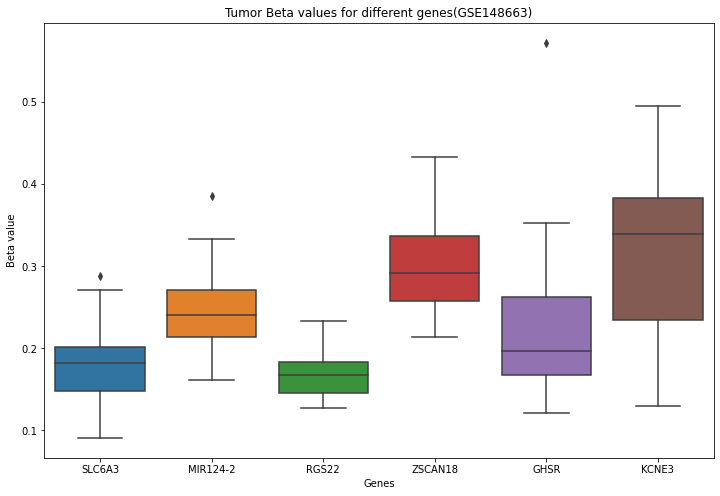

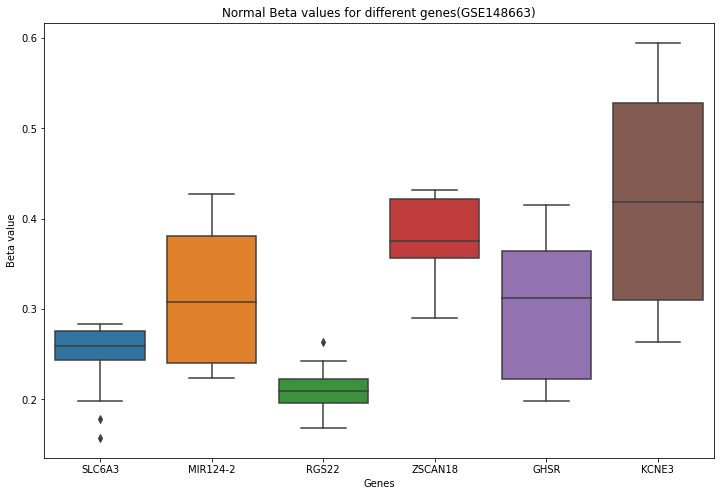

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_IQR_GSE148663(df,title):
    plt.figure(figsize=(12, 8))

    sns.boxplot(data=df.iloc[:,1::].T, orient='v')

    labels = ['SLC6A3', 'MIR124-2', 'RGS22', 'ZSCAN18', 'GHSR', 'KCNE3']
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
    plt.title(f'{title} Beta values for different genes(GSE148663)')
    plt.xlabel('Genes')
    plt.ylabel('Beta value')
    plt.show()

draw_IQR_GSE148663(liquid_tumor,'Tumor')
draw_IQR_GSE148663(liquid_normal,'Normal')

In [76]:
# 計算6個基因的Δβ
cal_dbeta(liquid_normal,liquid_tumor,liquid.iloc[:,0])

,Unnamed: 0,dbeta
31654,cg14502484,-0.069353
50299,cg07792478,-0.065863
53205,cg24848035,-0.045100
102837,cg14231297,-0.078170
176377,cg17152757,-0.096046
291276,cg04574090,-0.088982


結論：6個基因在2份液態資料甲基化表現不明顯

#### Step1：將GSE89093 和 GSE148663烏拉圭 正規化[0,1]

In [77]:
#GSE89093(46Normal/46Tumor)
import pandas as pd
liquid_GSE89093=pd.read_csv("../../乳癌液態/GSE89093/GSE89093_all_beta_normalized.csv")
liquid_label_GSE89093= liquid_GSE89093[liquid_GSE89093['0'].isin(['dummy'])].iloc[:,1::]
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297']
method_gene['Cluster']=[1,1,2,3,3,4]
liquid_GSE89093= liquid_GSE89093[liquid_GSE89093['0'].isin(method_gene['ID'])]

liquid_GSE89093

c:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
85611,cg04574090,0.087624,0.13261,0.132369,0.108854,0.1348,0.112986,0.157377,0.24022,0.132505,...,0.164045,0.123241,0.147084,0.138889,0.176534,0.238067,0.092072,0.203575,0.215459,0.122951
141557,cg07792478,0.106046,0.225343,0.196431,0.249864,0.217832,0.15622,0.207499,0.279335,0.15549,...,0.146672,0.184131,0.16246,0.223984,0.204782,0.254183,0.187526,0.196654,0.23652,0.170752
246866,cg14231297,0.148112,0.236885,0.256395,0.228758,0.232753,0.231946,0.305466,0.31597,0.221102,...,0.273318,0.215705,0.189755,0.209737,0.205174,0.330092,0.220389,0.198066,0.226701,0.26473
251927,cg14502484,0.080354,0.129113,0.105511,0.083873,0.124233,0.093481,0.115414,0.081157,0.085173,...,0.088834,0.095032,0.074643,0.08205,0.095737,0.208616,0.109698,0.112021,0.065706,0.094387
293600,cg17152757,0.079446,0.100336,0.116854,0.097704,0.174772,0.109604,0.101863,0.131156,0.086843,...,0.154693,0.092769,0.096713,0.12635,0.099148,0.135249,0.120283,0.156982,0.124908,0.13616
407311,cg24848035,0.051859,0.112657,0.099801,0.082997,0.104857,0.077364,0.094652,0.106195,0.065182,...,0.102195,0.100136,0.07892,0.101243,0.109812,0.16256,0.084828,0.086182,0.089821,0.117298


In [78]:
def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

liquid_GSE89093.iloc[:,1::]=liquid_GSE89093.iloc[:,1::].apply(min_max_normalize, axis=1)
liquid_GSE89093

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
85611,cg04574090,0.085597,0.287374,0.286293,0.180821,0.297194,0.199352,0.398461,0.770039,0.2869,...,0.428371,0.245349,0.352295,0.315536,0.484384,0.76038,0.105548,0.605674,0.658976,0.244049
141557,cg07792478,0.002821,0.414216,0.314515,0.498777,0.388315,0.175846,0.352682,0.600407,0.173329,...,0.142919,0.272098,0.197366,0.409531,0.343311,0.513669,0.283806,0.315282,0.452761,0.225961
246866,cg14231297,0.114683,0.439628,0.511041,0.40988,0.424504,0.421548,0.690661,0.729108,0.381856,...,0.572986,0.362099,0.267114,0.340255,0.323554,0.7808,0.379245,0.297536,0.40235,0.541552
251927,cg14502484,0.205798,0.470926,0.34259,0.224931,0.444391,0.277178,0.396437,0.210166,0.232002,...,0.25191,0.285609,0.174744,0.215017,0.289445,0.903226,0.365355,0.37799,0.126151,0.282104
293600,cg17152757,0.058204,0.127851,0.182924,0.119079,0.376025,0.158752,0.132943,0.230606,0.082865,...,0.309079,0.102624,0.115775,0.214584,0.123892,0.244253,0.194358,0.316711,0.209775,0.247289
407311,cg24848035,0.0,0.349096,0.275278,0.17879,0.304311,0.146445,0.245714,0.311993,0.076503,...,0.289025,0.277202,0.15538,0.283558,0.332758,0.635628,0.189306,0.197079,0.217973,0.375742


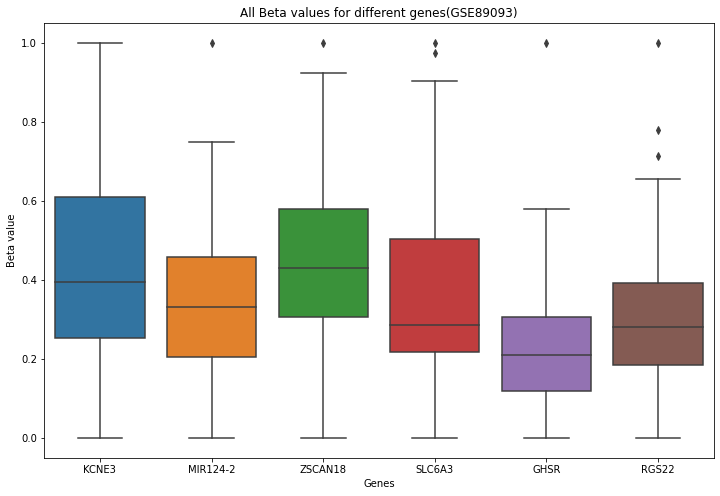

In [79]:
draw_IQR_GSE89093(liquid_GSE89093, "All")

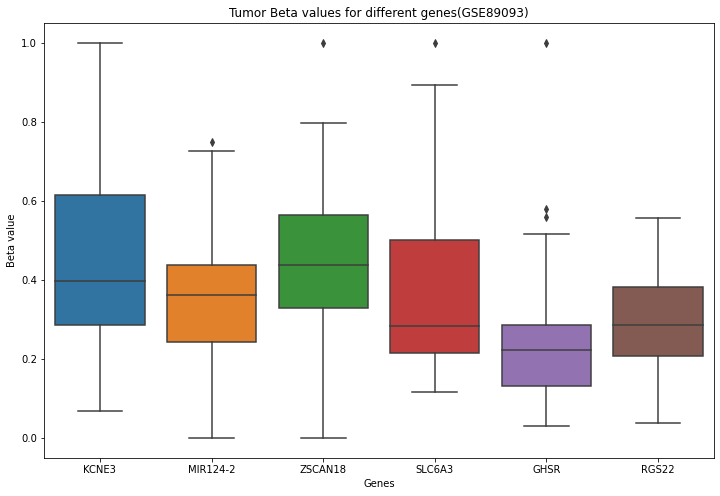

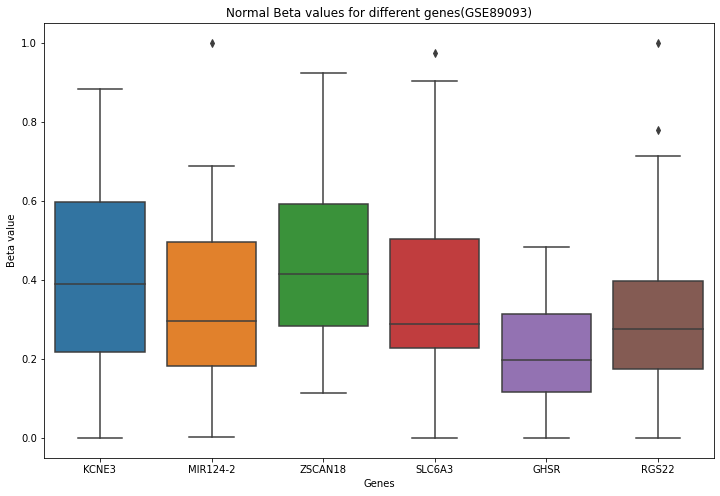

In [80]:
liquid_normal_GSE89093 = []
liquid_tumor_GSE89093 = []
for i in range(liquid_label_GSE89093.shape[1]):
    if liquid_label_GSE89093.iloc[0, i] == 'healthy':
        liquid_normal_GSE89093.append(liquid_GSE89093.iloc[:,i+1])
    else:
        liquid_tumor_GSE89093.append(liquid_GSE89093.iloc[:,i+1])
        
liquid_normal_GSE89093=pd.DataFrame(liquid_normal_GSE89093).T
liquid_tumor_GSE89093=pd.DataFrame(liquid_tumor_GSE89093).T
liquid_normal_GSE89093 = liquid_normal_GSE89093.astype(float)
liquid_tumor_GSE89093 = liquid_tumor_GSE89093.astype(float)
liquid_tumor_GSE89093=pd.concat([liquid_GSE89093.iloc[:, 0],liquid_tumor_GSE89093], axis=1)
liquid_normal_GSE89093=pd.concat([liquid_GSE89093.iloc[:, 0],liquid_normal_GSE89093], axis=1)
draw_IQR_GSE89093(liquid_tumor_GSE89093,'Tumor')
draw_IQR_GSE89093(liquid_normal_GSE89093,'Normal')

In [81]:
# 計算6個基因的Δβ
cal_dbeta(liquid_normal_GSE89093,liquid_tumor_GSE89093,liquid_GSE89093.iloc[:,0])

,0,dbeta
85611,cg04574090,0.004913
141557,cg07792478,0.025042
246866,cg14231297,0.025524
251927,cg14502484,-0.004971
293600,cg17152757,0.023521
407311,cg24848035,-0.035097


In [82]:
#GSE148663烏拉圭(22Normal/22Tumor)
liquid_GSE148663=pd.read_csv("../../乳癌液態/GSE148663烏拉圭/all_beta_normalized_breast_liquid_oversample_random.csv")
method_gene=pd.DataFrame(columns=['ID','Cluster'])
method_gene['ID']=['cg24848035','cg07792478','cg14502484','cg17152757','cg04574090','cg14231297']
method_gene['Cluster']=[1,1,2,3,3,4]
liquid_GSE148663= liquid_GSE148663[liquid_GSE148663['Unnamed: 0'].isin(method_gene['ID'])]

liquid_GSE148663.iloc[:, 1::]

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21
31654,0.205051,0.243212,0.259744,0.275523,0.198522,0.283869,0.275523,0.243212,0.259744,0.279790,...,0.157093,0.267130,0.199354,0.139707,0.128392,0.175718,0.287906,0.260111,0.197612,0.090689
50299,0.253777,0.268278,0.348533,0.427417,0.230685,0.383407,0.427417,0.268278,0.348533,0.235836,...,0.205022,0.385772,0.266477,0.183004,0.236001,0.229289,0.332963,0.269127,0.242391,0.161024
53205,0.183613,0.189180,0.215913,0.224664,0.202534,0.209803,0.224664,0.189180,0.215913,0.196645,...,0.171768,0.212201,0.142507,0.144872,0.160800,0.126820,0.178107,0.182490,0.193848,0.156214
102837,0.290047,0.371885,0.421400,0.431674,0.369174,0.401251,0.431674,0.371885,0.421400,0.351959,...,0.260778,0.396896,0.286947,0.254129,0.356989,0.255084,0.433508,0.371220,0.322125,0.214401
176377,0.218125,0.262243,0.415552,0.363892,0.222247,0.362775,0.363892,0.262243,0.415552,0.198268,...,0.123788,0.352934,0.200195,0.124532,0.138041,0.271143,0.167427,0.572455,0.282025,0.194151
291276,0.351352,0.300938,0.528000,0.594904,0.362397,0.468654,0.594904,0.300938,0.528000,0.263153,...,0.229533,0.443259,0.334782,0.166949,0.344996,0.227562,0.472871,0.494785,0.392069,0.129789


In [83]:
def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

liquid_GSE148663.iloc[:,1::]=liquid_GSE148663.iloc[:,1::].apply(min_max_normalize, axis=1)
liquid_GSE148663

,Unnamed: 0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21
31654,cg14502484,0.579878,0.773376,0.857205,0.937210,0.546771,0.979531,0.937210,0.773376,0.857205,...,0.336706,0.894654,0.550993,0.248549,0.191177,0.431145,1.000000,0.859066,0.542157,0.000000
50299,cg07792478,0.348182,0.402614,0.703881,1.000000,0.261494,0.834791,1.000000,0.402614,0.703881,...,0.165161,0.843671,0.395854,0.082508,0.281451,0.256254,0.645433,0.405802,0.305439,0.000000
53205,cg24848035,0.415752,0.456511,0.652203,0.716270,0.554267,0.607480,0.716270,0.456511,0.652203,...,0.329044,0.625036,0.114835,0.132148,0.248750,0.000000,0.375449,0.407533,0.490676,0.215176
102837,cg14231297,0.345250,0.718757,0.944742,0.991634,0.706382,0.852783,0.991634,0.718757,0.944742,...,0.211665,0.832906,0.331099,0.181318,0.650772,0.185678,1.000000,0.715722,0.491652,0.000000
176377,cg17152757,0.214869,0.312627,0.652332,0.537861,0.224003,0.535386,0.537861,0.312627,0.652332,...,0.005835,0.513581,0.175140,0.007482,0.037416,0.332348,0.102532,1.000000,0.356461,0.161746
291276,cg04574090,0.476361,0.367970,0.856156,1.000000,0.500109,0.728563,1.000000,0.367970,0.856156,...,0.214450,0.673963,0.440737,0.079893,0.462696,0.210213,0.737628,0.784743,0.563905,0.000000


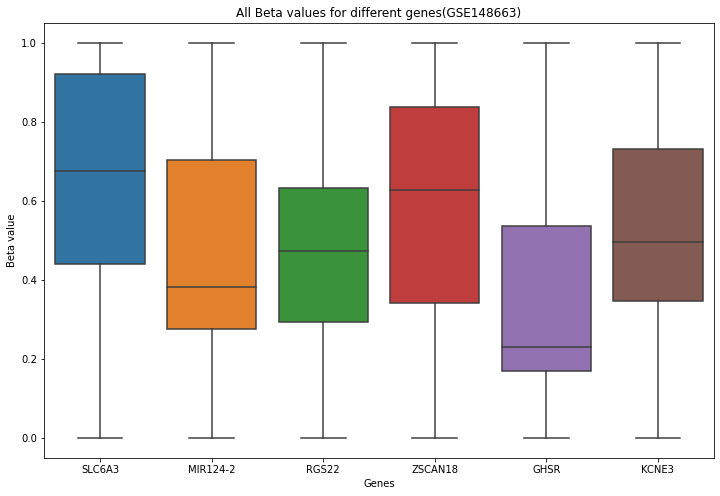

In [84]:
draw_IQR_GSE148663(liquid_GSE148663, "All")

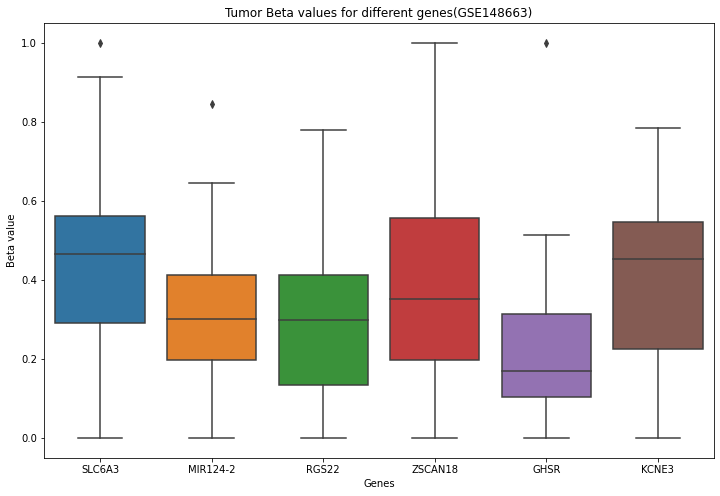

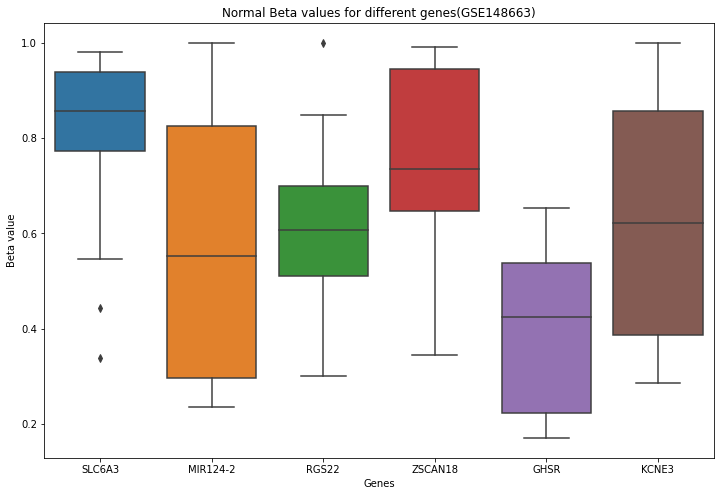

In [85]:
liquid_normal_GSE148663 = []
liquid_tumor_GSE148663 = []
for i in range(44):
    if i < 22:
        liquid_normal_GSE148663.append(liquid_GSE148663.iloc[:,i+1])
    else:
        liquid_tumor_GSE148663.append(liquid_GSE148663.iloc[:,i+1])

liquid_normal_GSE148663=pd.DataFrame(liquid_normal_GSE148663).T
liquid_tumor_GSE148663=pd.DataFrame(liquid_tumor_GSE148663).T
liquid_normal_GSE148663 = liquid_normal_GSE148663.astype(float)
liquid_tumor_GSE148663 = liquid_tumor_GSE148663.astype(float)
liquid_tumor_GSE148663=pd.concat([liquid_GSE148663.iloc[:, 0],liquid_tumor_GSE148663], axis=1)
liquid_normal_GSE148663=pd.concat([liquid_GSE148663.iloc[:, 0],liquid_normal_GSE148663], axis=1)

draw_IQR_GSE148663(liquid_tumor_GSE148663,'Tumor')
draw_IQR_GSE148663(liquid_normal_GSE148663,'Normal')

In [86]:
# 計算6個基因的Δβ
cal_dbeta(liquid_normal_GSE148663,liquid_tumor_GSE148663,liquid_GSE148663.iloc[:,0])

,Unnamed: 0,dbeta
31654,cg14502484,-0.331080
50299,cg07792478,-0.271465
53205,cg24848035,-0.307977
102837,cg14231297,-0.343181
176377,cg17152757,-0.224784
291276,cg04574090,-0.237760


#### Step2：將正規化後的兩份資料集混合，做cv=5模型預測

In [87]:
liquid_GSE89093.set_index('0', inplace=True)#df1
liquid_GSE148663.set_index('Unnamed: 0', inplace=True)#df2

liquid = pd.merge(liquid_GSE89093, liquid_GSE148663, left_index=True, right_index=True, suffixes=('_df1', '_df2'))
liquid.reset_index(inplace=True)

liquid

,index,1_df1,2,3,4,5,6,7,8,9,...,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21
0,cg04574090,0.085597,0.287374,0.286293,0.180821,0.297194,0.199352,0.398461,0.770039,0.2869,...,0.214450,0.673963,0.440737,0.079893,0.462696,0.210213,0.737628,0.784743,0.563905,0.000000
1,cg07792478,0.002821,0.414216,0.314515,0.498777,0.388315,0.175846,0.352682,0.600407,0.173329,...,0.165161,0.843671,0.395854,0.082508,0.281451,0.256254,0.645433,0.405802,0.305439,0.000000
2,cg14231297,0.114683,0.439628,0.511041,0.40988,0.424504,0.421548,0.690661,0.729108,0.381856,...,0.211665,0.832906,0.331099,0.181318,0.650772,0.185678,1.000000,0.715722,0.491652,0.000000
3,cg14502484,0.205798,0.470926,0.34259,0.224931,0.444391,0.277178,0.396437,0.210166,0.232002,...,0.336706,0.894654,0.550993,0.248549,0.191177,0.431145,1.000000,0.859066,0.542157,0.000000
4,cg17152757,0.058204,0.127851,0.182924,0.119079,0.376025,0.158752,0.132943,0.230606,0.082865,...,0.005835,0.513581,0.175140,0.007482,0.037416,0.332348,0.102532,1.000000,0.356461,0.161746
5,cg24848035,0.0,0.349096,0.275278,0.17879,0.304311,0.146445,0.245714,0.311993,0.076503,...,0.329044,0.625036,0.114835,0.132148,0.248750,0.000000,0.375449,0.407533,0.490676,0.215176


In [88]:
liquid_label_GSE148663 = [ (0 if i < 22 else 1)  for i in range(44)]
liquid_label_GSE89093 = [0 if liquid_label_GSE89093.iloc[0, i] == 'healthy' else 1 for i in range(liquid_label_GSE89093.shape[1])]
liquid_label=liquid_label_GSE89093+liquid_label_GSE148663

In [89]:
y=liquid_label

In [90]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score,confusion_matrix,accuracy_score
from itertools import combinations
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [91]:
def is_unique(lst):
    return len(lst) == len(set(lst))

In [92]:
#cv=5
target_labels = method_gene['ID']
# 四個一組
combinations_list = list(combinations(target_labels, 4))
result=[]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 1
}
models = {
    'XGBoost': xgb.XGBClassifier(**params),
    'RandomForest': RandomForestClassifier(n_estimators=100, 
                                            max_depth=10, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2,
                                            min_impurity_decrease=0.0,
                                            random_state=42),
    'SVM': SVC(kernel='linear'),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

for model_name, model in models.items():

    # 所有可能的組合
    for combination in combinations_list:

        GO_1=int(method_gene.loc[method_gene['ID'] == combination[0]]["Cluster"])
        GO_2=int(method_gene.loc[method_gene['ID'] == combination[1]]["Cluster"])
        GO_3=int(method_gene.loc[method_gene['ID'] == combination[2]]["Cluster"])
        GO_4=int(method_gene.loc[method_gene['ID'] == combination[3]]["Cluster"])

        lst=[GO_1,GO_2,GO_3,GO_4]

        if(is_unique(lst)):
            d1_values = liquid.loc[liquid['index']==combination[0]]
            d2_values = liquid.loc[liquid['index']==combination[1]]
            d3_values = liquid.loc[liquid['index']==combination[2]]
            d4_values = liquid.loc[liquid['index']==combination[3]]
        
            d1 = d1_values.iloc[:, 1::]
            d2 = d2_values.iloc[:, 1::]
            d3 = d3_values.iloc[:, 1::]
            d4 = d4_values.iloc[:, 1::]

            d1 = d1.values.flatten().tolist()
            d2 = d2.values.flatten().tolist()
            d3 = d3.values.flatten().tolist()
            d4 = d4.values.flatten().tolist()

            x = []

            for i in range(136):
                x.append([d1[i],d2[i],d3[i],d4[i]])
                
            cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
            accuracy = cv_scores.mean()

            y_pred = cross_val_predict(model, x, y, cv=5)

            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(y, y_pred)
            f1 = f1_score(y, y_pred)
            precision = tp / (tp + fp)
            sorted_combination = [x for _, x in sorted(zip(lst, combination))]
            result.append([model_name] + sorted_combination + [accuracy, auc_score, f1, sensitivity, specificity,precision])
            
# result

In [93]:
from sklearn.metrics import classification_report
import numpy as np
print(classification_report(y,y_pred,labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           0       0.47      0.53      0.50        68
           1       0.47      0.41      0.44        68

    accuracy                           0.47       136
   macro avg       0.47      0.47      0.47       136
weighted avg       0.47      0.47      0.47       136



In [94]:
df=pd.DataFrame(result, columns=['Model','ID1', 'ID2', 'ID3','ID4', 'accuracy','AUC','f1_score','sensitivity','specificity','precision'])
df.to_csv("../result/liquid_predict/liquid_combination_GSE89093&148663.csv", index=False)